# Mineral Classification by Utilizing a PyTorch Deep Learning Neural Network

## About

This notebook utilizes a dataset of 953 images of 7 different types of minerals (biotite, bornite, chrysocolla, malachite, muscovite, pyrite, and quartz).  Identification of minerals typically requires expertise and can take a significant amount of time.  This notebook aims to create a deep learning AI model that can effectively identify minerals without the eyes of an expert.  Special thanks to Kofi Asiedu Brempong and Albert Klu from the University of Mines and Technology in Tarkwa Ghana for providing the dataset.

## Import Libraries

In [133]:
import torch
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

## Read Data and Explore

In [134]:
#Set data_path, target_labels, and device

dataset_path = '../data/raw'
target_labels = ['biotite', 'bornite', 'chrysocolla', 'malachite', 'muscovite', 'pyrite', 'quartz']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [135]:
#Load data and transform into a tensor for Pytorch

dataset = ImageFolder(dataset_path, transform=transforms.ToTensor())
print('There are', len(dataset), 'images in the dataset, consisting of', len(dataset.classes), 'different classes.')
print('\nThe classes are as follows', dataset.classes, '.')

There are 953 images in the dataset, consisting of 7 different classes.

The classes are as follows ['biotite', 'bornite', 'chrysocolla', 'malachite', 'muscovite', 'pyrite', 'quartz'] .


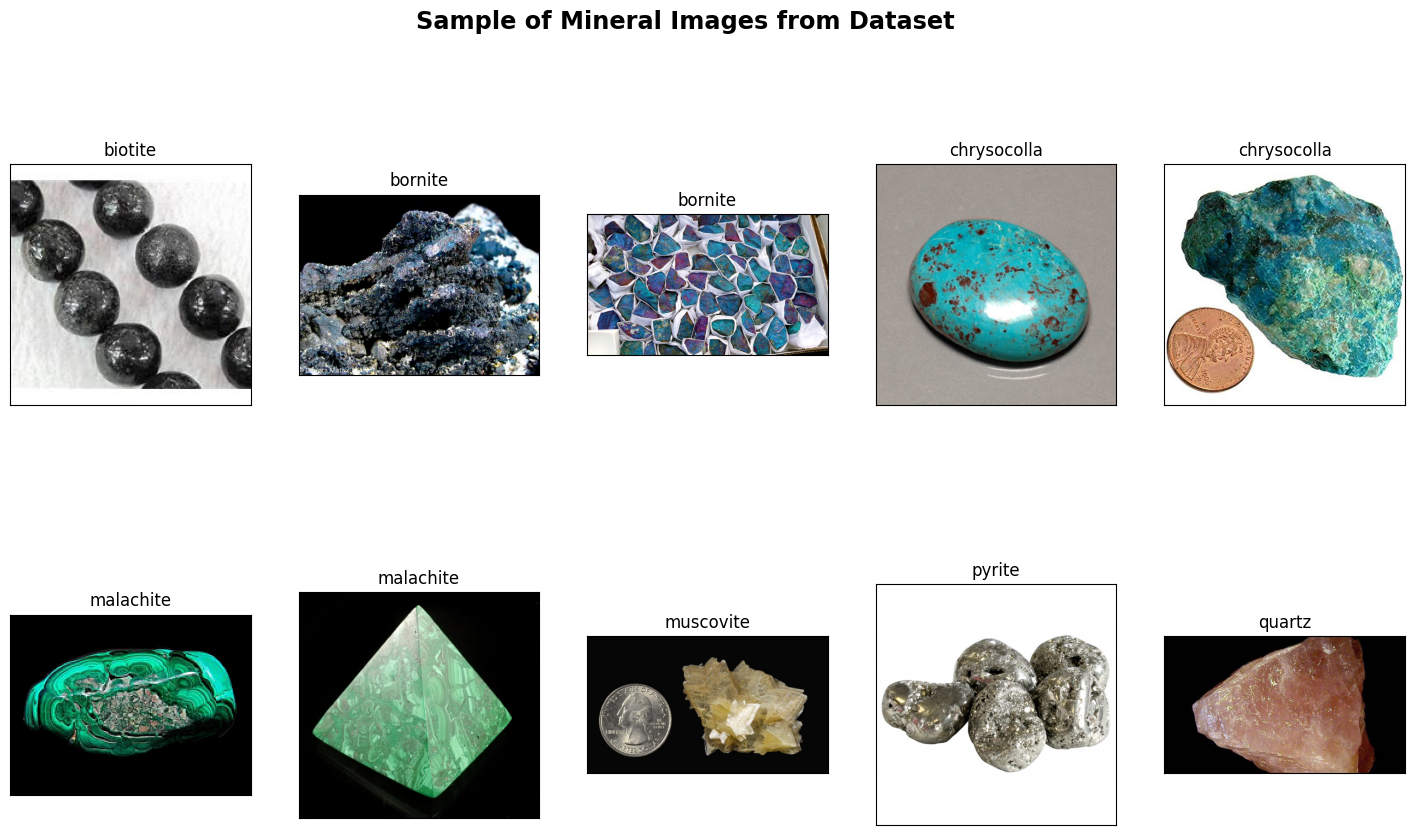

In [136]:
#View a sample of the images

num_images = 10 #number of images to view
images_per_row = 5 #number of images per row of display

fig, axes = plt.subplots(num_images//images_per_row + int(num_images%images_per_row > 0), images_per_row, figsize=(18,10))
axes = axes.flatten()



for i in range(num_images):
    image, label = dataset[i + (i*len(dataset)//num_images)]
    axes[i].imshow(image.permute(1,2,0))
    axes[i].set_title(target_labels[label])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.suptitle('Sample of Mineral Images from Dataset', fontweight='bold', fontsize='xx-large')
plt.show()

In [137]:
#Count number for each label

count = Counter()

for i in range(len(dataset)):
    _, labels = dataset[i]
    count[target_labels[labels]] += 1

# Insert count into pandas dataframe
df = pd.DataFrame(count, index=np.arange(1))
df = df.transpose().reset_index()
df.columns = ['Mineral', 'Count']
df = df.sort_values('Count', ascending=False)
df

,Mineral,Count
3,malachite,235
1,bornite,170
2,chrysocolla,163
6,quartz,142
5,pyrite,98
4,muscovite,77
0,biotite,68


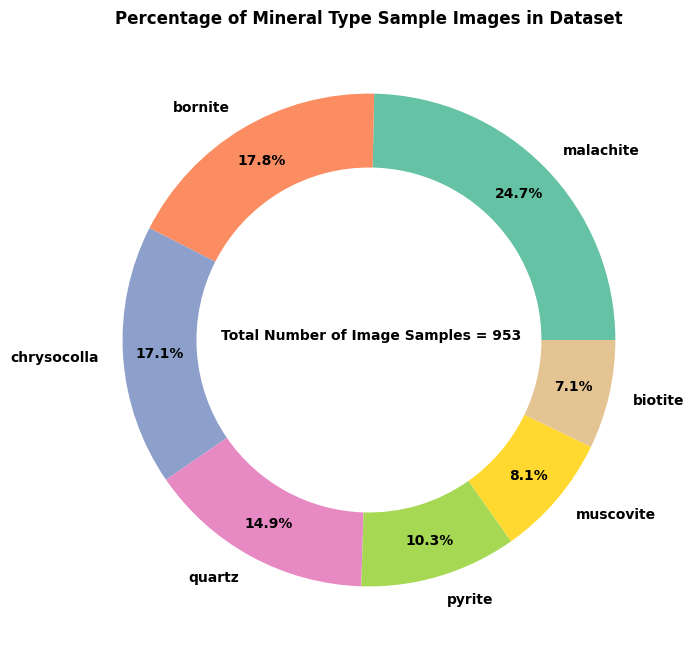

In [138]:
# Donut plot of image distribution by mineral type in dataset

fig, axes = plt.subplots(1, 1, figsize=(8,8))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']

axes.pie(df['Count'], labels = df['Mineral'], colors=colors, autopct='%1.1f%%', pctdistance=0.85, wedgeprops=dict(width=0.3), textprops={'weight':'bold'})
axes.set_title('Percentage of Mineral Type Sample Images in Dataset', fontweight='bold')
plt.text(-0.6, 0, s='Total Number of Image Samples = %0.0f'%df['Count'].sum(), fontsize=10, fontweight='bold')

plt.show()


In [139]:
# Check image sizes of dataset

height = []
width = []
for i in range(len(dataset)):
    image, label = dataset[i]
    height.append(image.size(1))
    width.append(image.size(2))
print('The dataset images have the following size characteristics. \n')
print(f'maximum_height:{np.max(height)} \tminimum_height:{np.min(height)} \tmean_height:{np.mean(height):0.0f}')
print(f'maximum_width:{np.max(width)} \tminimum_width:{np.min(width)} \tmean_width:{np.mean(width):0.0f}')

The dataset images have the following size characteristics. 

maximum_height:6016 	minimum_height:129 	mean_height:696
maximum_width:6016 	minimum_width:144 	mean_width:806


## Data Transformations for PyTorch NN Model

In [140]:
#Resize images, perform random transformations to improve network generalization, and normalize channel pixel intensities

data_transform = transforms.Compose([transforms.Resize((224, 224)), #Smaller size for faster training, 
                                     transforms.RandomRotation(30), 
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])]) #Imagenet basic settings

load_data = ImageFolder(dataset_path, transform=data_transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

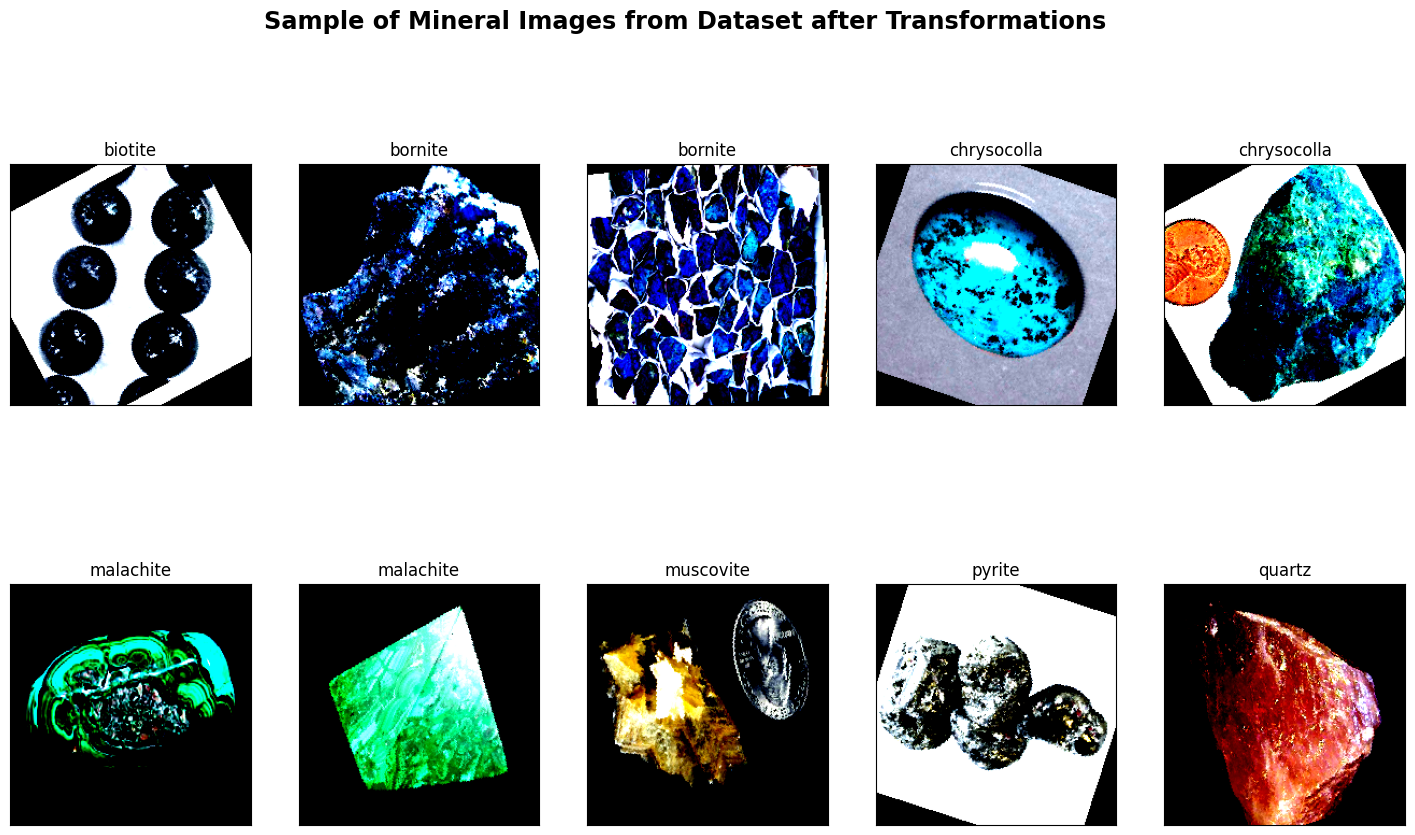

In [141]:
num_images = 10 #number of images to view
images_per_row = 5 #number of images per row of display

fig, axes = plt.subplots(num_images//images_per_row + int(num_images%images_per_row > 0), images_per_row, figsize=(18,10))
axes = axes.flatten()

for i in range(num_images):
    image, label = load_data[i + (i*len(load_data)//num_images)]
    axes[i].imshow(image.permute(1,2,0))
    axes[i].set_title(target_labels[label])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.suptitle('Sample of Mineral Images from Dataset after Transformations', fontweight='bold', fontsize='xx-large')
plt.show()

## Perform a Stratified Split

In [143]:
X = list(range(0,len(dataset))) #Image indexes for entire dataset
y = [] #List of target values

for i in range(len(dataset)):
    y.append(dataset[i][1])

# Create Train, Validation, and Test Sets

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=8)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=8)

In [144]:
#function for plotting distribution of splits
def plot_dist(indexes, dataset=dataset, title='Data Distribution'):
    
    count = Counter()
    for i in indexes:
        _, label = dataset[i]
        count[target_labels[label]] += 1

    dist = dict(sorted(count.items(), key=lambda kv: kv[1], reverse=True))
    plt.bar(dist.keys(), dist.values())
    plt.xticks(rotation=30)
    plt.title(title); plt.ylabel('count')
    plt.show()

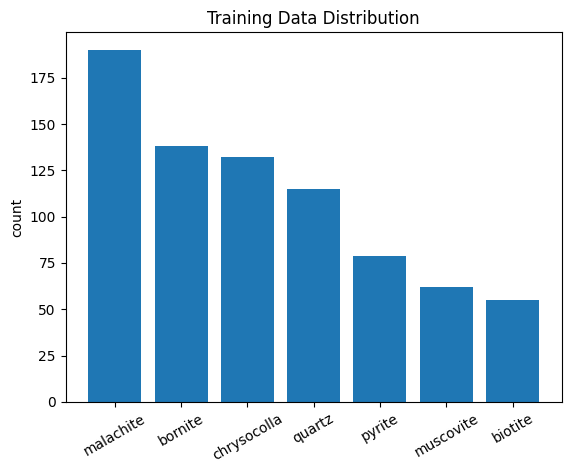

In [145]:
plot_dist(X_train, title='Training Data Distribution')

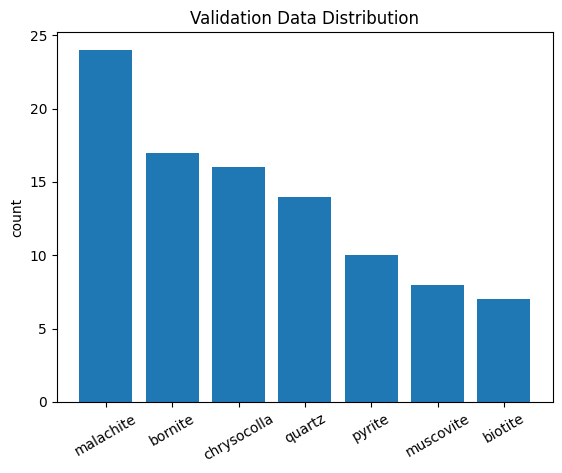

In [147]:
plot_dist(X_val, title='Validation Data Distribution')

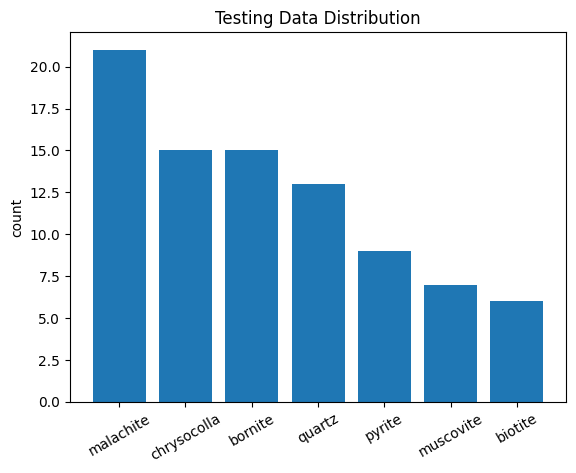

In [148]:
plot_dist(X_test, title='Testing Data Distribution')

## Data Loading for PyTorch NN Model

In [149]:
batch_size = 128

train_set = SubsetRandomSampler(X_train)
val_set = SubsetRandomSampler(X_val)
test_set = SubsetRandomSampler(X_test)

#dataloader
train_loader = DataLoader(load_data, batch_size=batch_size, 
                          shuffle=False, sampler= train_set)
val_loader = DataLoader(load_data, batch_size=batch_size,  
                        sampler=val_set)
test_loader = DataLoader(load_data, batch_size=batch_size,
                        sampler=test_set)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 224, 224])


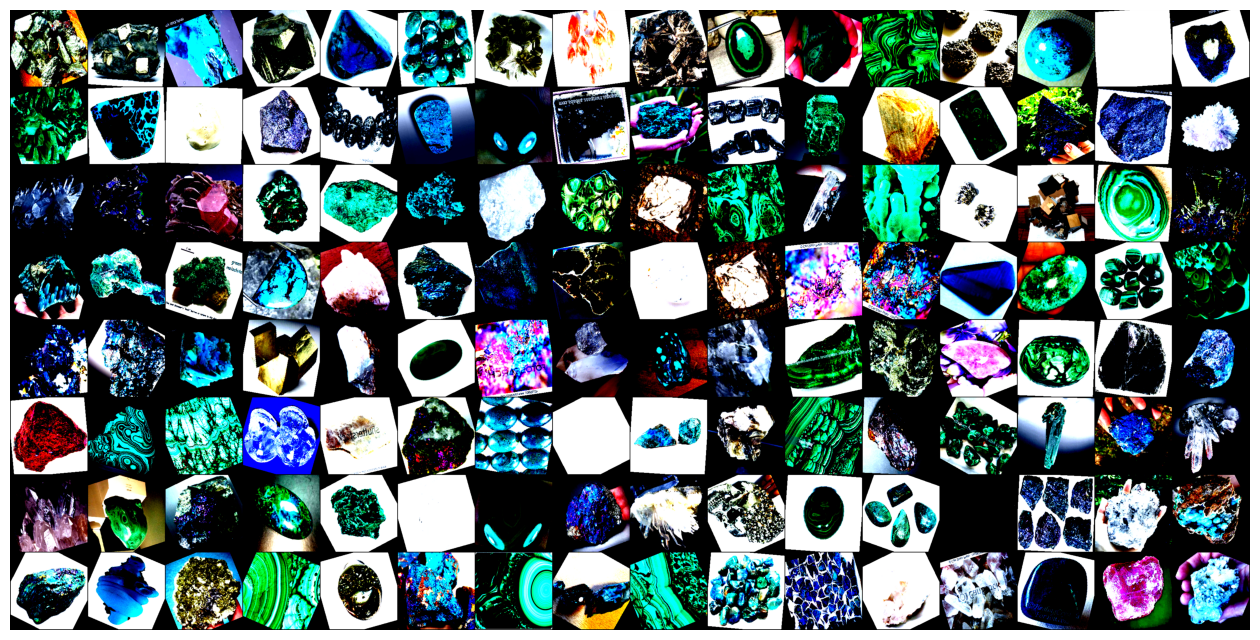

In [150]:
#Check one image batch of the train data loader
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Build PyTorch Model

In [151]:
class Mineral_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 48, 11, stride=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1), #out 70x70

            nn.Conv2d(48, 128, 5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1),#out 64x64

            nn.Conv2d(128, 128, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(4, 3),#out 20x20

            nn.Conv2d(128, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),#out 20x20

            nn.Flatten(),
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 7),
            nn.LogSoftmax(dim=1),
            )
        
    def forward(self, x):
        out = self.net(x)
        return out

model = Mineral_Classifier()
model.to(device)
model

Mineral_Classifier(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax(dim=1)
  )
)

## Train PyTorch Model

In [152]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    test_losses = []
    train_accu = []
    val_accu = []
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        train_acc = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            image = image.to(device); label = label.to(device);

            output = model(image)
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            correct = top_class == label.view(*top_class.shape)
            train_acc += torch.mean(correct.type(torch.FloatTensor))

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for image, label in val_loader:
                    image = image.to(device); label = label.to(device);

                    output = model(image)
                    loss = criterion(output, label)

                    ps = torch.exp(output)
                    _, top_class = ps.topk(1, dim=1)
                    correct = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(correct.type(torch.FloatTensor))

                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            train_accu.append(train_acc/len(train_loader))
            val_accu.append(accuracy/len(val_loader))
            model.train()
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Train Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
                  "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                  "Test Accuracy: {:.3f}.. ".format(accuracy/len(val_loader)),
                  "Time: {:.2f}s" .format((time.time()-since)))
    
    history = {'train_loss' : train_losses, 'val_loss': test_losses, 
               'train_accuracy': train_accu, 'val_accuracy':val_accu}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [153]:
#saving model
def save_model(model, optim, fpath):
    checkpoint = {'model' : model,
                'state_dict': model.state_dict(),
                'optim' : optim.state_dict()
                }

    torch.save(checkpoint, fpath)

#load model
def load_model(fpath, inferece = True):
    check = torch.load(fpath)
    model = check['model']
    model.load_state_dict(check['state_dict'])
    if inferece:
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
    else:
        model.train()
    return model

In [154]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epoch = 40
history_mineral = fit(epoch, model, train_loader, val_loader, criterion, optimizer)

Epoch: 1/40..  Train Loss: 1.889..  Test Loss: 1.818..  Train Accuracy: 0.234..  Test Accuracy: 0.250..  Time: 12.92s
Epoch: 2/40..  Train Loss: 1.744..  Test Loss: 1.689..  Train Accuracy: 0.286..  Test Accuracy: 0.354..  Time: 12.14s
Epoch: 3/40..  Train Loss: 1.616..  Test Loss: 1.500..  Train Accuracy: 0.430..  Test Accuracy: 0.417..  Time: 12.29s
Epoch: 4/40..  Train Loss: 1.381..  Test Loss: 1.419..  Train Accuracy: 0.414..  Test Accuracy: 0.354..  Time: 12.24s
Epoch: 5/40..  Train Loss: 1.478..  Test Loss: 1.233..  Train Accuracy: 0.417..  Test Accuracy: 0.490..  Time: 12.12s
Epoch: 6/40..  Train Loss: 1.389..  Test Loss: 1.174..  Train Accuracy: 0.481..  Test Accuracy: 0.573..  Time: 12.18s
Epoch: 7/40..  Train Loss: 1.298..  Test Loss: 1.125..  Train Accuracy: 0.503..  Test Accuracy: 0.573..  Time: 12.26s
Epoch: 8/40..  Train Loss: 1.130..  Test Loss: 1.161..  Train Accuracy: 0.552..  Test Accuracy: 0.521..  Time: 12.38s
Epoch: 9/40..  Train Loss: 1.034..  Test Loss: 1.034..  

In [155]:
#save model
save_model(model, optimizer, 'mineral_classifier.pt')

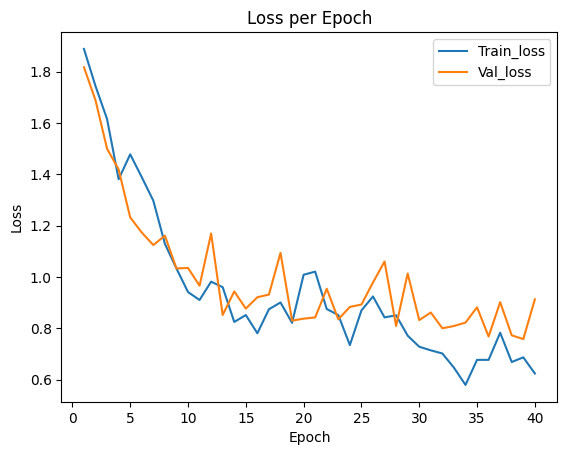

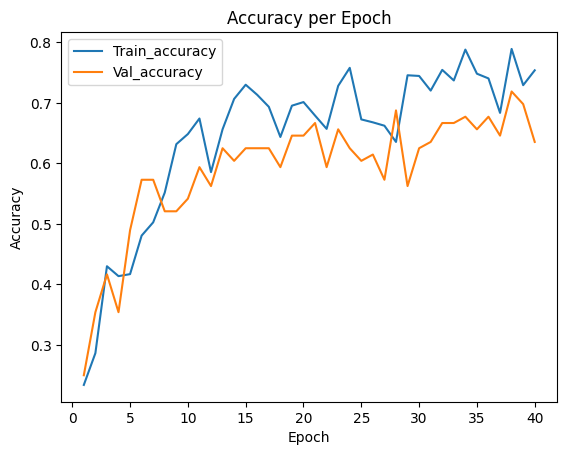

In [157]:
def plot_loss(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_loss'], label='Train_loss')
    plt.plot(epoch, history['val_loss'], label='Val_loss')
    plt.title('Loss per Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(); 
    plt.show()

def plot_accuracy(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_accuracy'], label='Train_accuracy')
    plt.plot(epoch, history['val_accuracy'], label='Val_accuracy')
    plt.title('Accuracy per Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(); 
    plt.show()
plot_loss(history_mineral, epoch)
plot_accuracy(history_mineral, epoch)

## Prediction and Evaluation of Model

In [158]:
def predict_label(model, dataloader):
    prediction_list = []
    labels = []
    model.to(device)
    model.eval()
    for i, batch in enumerate(dataloader):
        image, label = batch
        image = image.to(device); label = label.to(device)
      
        out = model(image)
        ps = torch.exp(out)
        _, top_class = torch.max(ps , 1)
        preds = np.squeeze(top_class.cpu().numpy())
        prediction_list.append(preds)
        labels.append(label.cpu().numpy())
    return np.squeeze(prediction_list), np.squeeze(labels)

In [164]:
model = load_model('mineral_classifier.pt', inferece=True)
model

Mineral_Classifier(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax(dim=1)
  )
)

In [165]:
# Make predictions on Test Data
y_predict, y_true = predict_label(model_mineral, test_loader)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.76      0.87      0.81        15
           2       0.68      0.87      0.76        15
           3       0.90      0.86      0.88        21
           4       0.50      0.14      0.22         7
           5       0.54      0.78      0.64         9
           6       1.00      0.77      0.87        13

    accuracy                           0.77        86
   macro avg       0.74      0.71      0.70        86
weighted avg       0.78      0.77      0.76        86



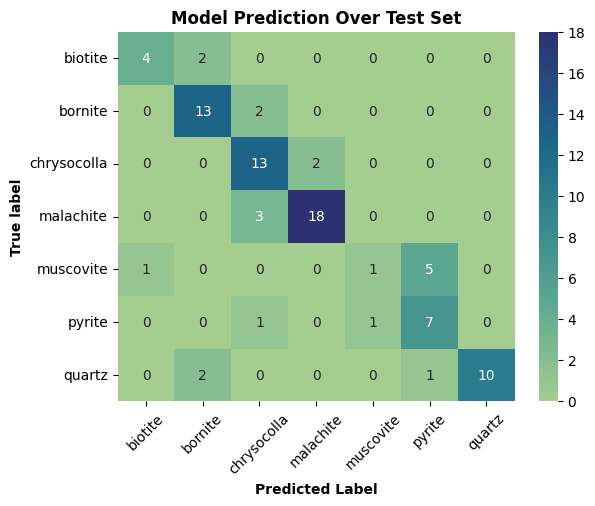

In [170]:
#plot confusion matric
print(classification_report(y_true, y_predict))
sns.heatmap(confusion_matrix(y_true, y_predict), annot=True, cmap='crest')
plt.ylabel('True label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.yticks(np.arange(0.5, len(target_labels)), labels=target_labels, rotation=0);
plt.xticks(np.arange(0.5, len(target_labels)), labels=target_labels, rotation=45)
plt.title('Model Prediction Over Test Set', fontweight='bold')
plt.show()

## Conclusion

A PyTorch CNN (convolutional neural network) can be an effective classifier of minerals based on images.  However, the model does seem to struggle with classifying muscovite and frequently classifies it as pyrite instead.  This is likely due to the similar goldish color of the two minerals.  It may be possible to improve this performance with additional training data or additional features (such as additional spectrums besides RGB).  

Next steps include
- comparing the performance of this model with pretrained vision models
- additional tuning of the models hyperparameters
- trying out different model architectures to see if it improves performance